In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow_io.python.ops.audio_ops import spectrogram
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds

from utils import play_audio, display_spectrogram, display_wave, compare_histories, render_history

In [ ]:
(dataset_train_original, dataset_validate_original), info =tfds.load(
    "spoken_digit",
    split = ["train[:80%]","train[:80%]"],
    with_info =True
)

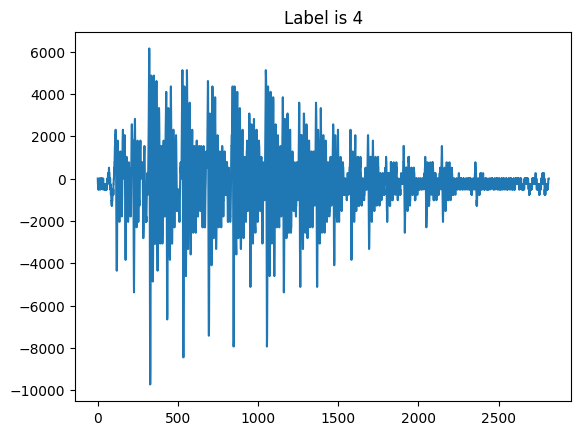

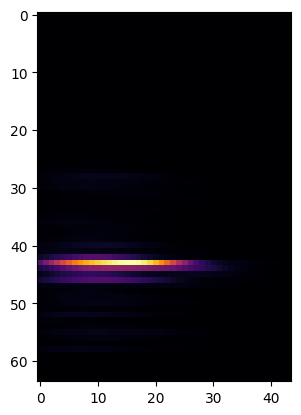

In [ ]:
for sample in dataset_train_original.shuffle(2500).take(1):
  display_wave(sample)
  play_audio(sample, sr = 8000)
  display_spectrogram(sample)

In [39]:
def preprocess(sample):
  audio = sample["audio"]
  label = sample["label"]
  audio = tf.cast(audio, tf.float32) / 32768.0
  spectrogram = tfio.audio.spectrogram(audio, nfft=1024, window=1024, stride=64)
  spectrogram = tfio.audio.melscale(spectrogram, rate = 8000, mels=64, fmin = 0, fmax = 2000)
  spectrogram /= tf.math.reduce_max(spectrogram)
  spectrogram =tf.expand_dims(spectrogram, axis = -1)
  spectrogram = spectrogram[::-1,:,:]
  spectrogram = tf.image.resize(spectrogram, (64,64))
  spectrogram = tf.transpose(spectrogram, perm = (1,0,2))#

  return spectrogram, label

dataset = dataset_train_original.map(lambda sample: preprocess(sample))
for x,y in dataset.shuffle(2000).take(1):
  plt.imshow(x[:,:,0], cmap="inferno")
  plt.title(f"Label is {y}")
  plt.show()
  plt.close
  break


In [ ]:
dataset_train = dataset_train_original.map(lambda sample: preprocess(sample))
datseat_train = dataset_train.cache()
datseat_train = dataset_train.shuffle(2000)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda sample: preprocess(sample))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)

In [ ]:
history_list={}
EPOCHS = 25
#uncomment below block to add checkpoint callback and run model.fit with the checkpoint if needed
'''
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)'''

In [48]:
model = models.Sequential()
model.add(layers.Conv2D(4,(3,3), padding = "same", activation = "relu", input_shape = (64,64,1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8,(3,3), padding = "same", activation = "relu" ))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8,(3,3), padding = "same", activation = "relu",))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16,(3,3), padding = "same", activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation = "softmax"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]

)

history = model.fit(
    dataset_train,
    epochs = EPOCHS,
    validation_data=dataset_validate

)


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 8, 8)          

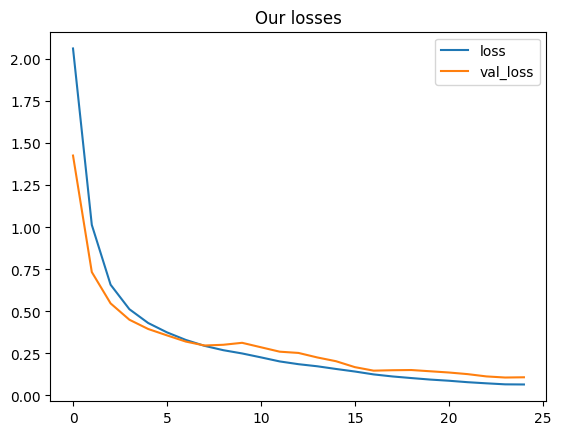

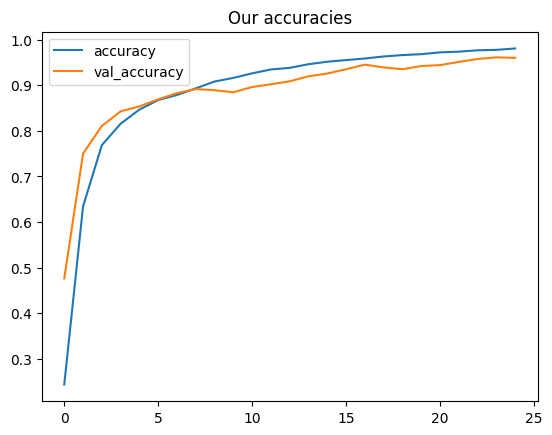

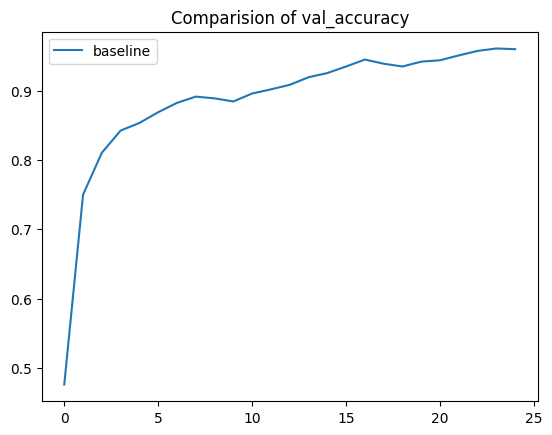

In [47]:
history_list["baseline"] = history.history
render_history(history.history)
compare_histories(history_list)

In [ ]:
model.save("./models/model")

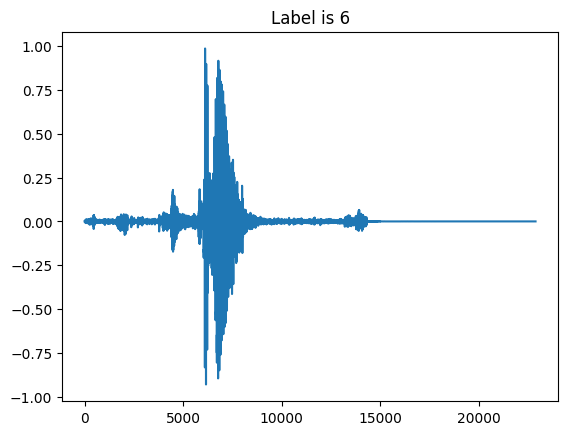

In [47]:
y, s = librosa.load('/content/spoke_6.wav', sr=8000)
y = y.astype("float32")

sample = {"audio":y,"label":6 ,"filename":"spoke_6"}

plt.plot(sample["audio"])
plt.title(f"Label is {sample['label']}")
plt.show()
plt.close()

display(Audio(y, rate=s))

In [35]:
test_model = load_model("./models/model")

In [43]:
test = tf.data.Dataset.from_tensors(sample)
testing = test.map(lambda sample:preprocess(sample))
testing = testing.batch(32)

In [44]:
result = test_model.predict(testing)

1/1 [==============================] - 1s 704ms/step


In [46]:
import numpy as np
np.argmax(result)

6